In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [2]:
training_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("\n\nNumber of data points in training data", training_data.shape)
print("\n\nThe attributes of data :", training_data.columns.values)
print('\n')
training_data.head(2)



Number of data points in training data (109248, 17)


The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']




Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

## Preprocessing teacher_prefix

In [4]:
training_data['teacher_prefix'] = training_data['teacher_prefix'].replace(np.nan,'MRS')
training_data['teacher_prefix'] = training_data['teacher_prefix'].replace('Dr.','DR')
training_data['teacher_prefix'] = training_data['teacher_prefix'].replace('Teacher','TEACHER')
training_data['teacher_prefix'] = training_data['teacher_prefix'].replace('Mr.','MR')
training_data['teacher_prefix'] = training_data['teacher_prefix'].replace('Ms.','MS')
training_data['teacher_prefix'] = training_data['teacher_prefix'].replace('Mrs.','MRS')
print(training_data['teacher_prefix'].head(5))
training_data.head(2)

0    MRS
1     MR
2     MS
3    MRS
4    MRS
Name: teacher_prefix, dtype: object


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            MRS   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             MR   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

### Summary

* Removing np.nan values from teacher_prefix column and converting to MRS
* Removing Full stops from teacher_prefix column and converting to Upper case

## Preprocessing project_grade_category

In [5]:
training_data['project_grade_category'] = training_data['project_grade_category'].replace('Grades PreK-2', 'Grades_PreK_2')
training_data['project_grade_category'] = training_data['project_grade_category'].replace('Grades 3-5', 'Grades_3_5')
training_data['project_grade_category'] = training_data['project_grade_category'].replace('Grades 6-8', 'Grades_6_8')
training_data['project_grade_category'] = training_data['project_grade_category'].replace('Grades 9-12', 'Grades_9_12')
print(training_data['project_grade_category'].head(5))
training_data.head(2)

0    Grades_PreK_2
1       Grades_6_8
2       Grades_6_8
3    Grades_PreK_2
4    Grades_PreK_2
Name: project_grade_category, dtype: object


Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            MRS   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             MR   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades_PreK_2   
1           FL        2016-10-25 09:22:10             Grades_6_8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

### Summary

* Replacing ' ' and '-' with '_' for all the values of project_grade_category column

In [6]:
print("\n\nNumber of data points in resource data", resource_data.shape)
print("\n\nThe attributes of data :",resource_data.columns.values)
resource_data.head(2)



Number of data points in resource data (1541272, 4)


The attributes of data : ['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

# Data Analysis

Number of projects that are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects that are not approved for funding  16542 , ( 15.141695957820739 %)


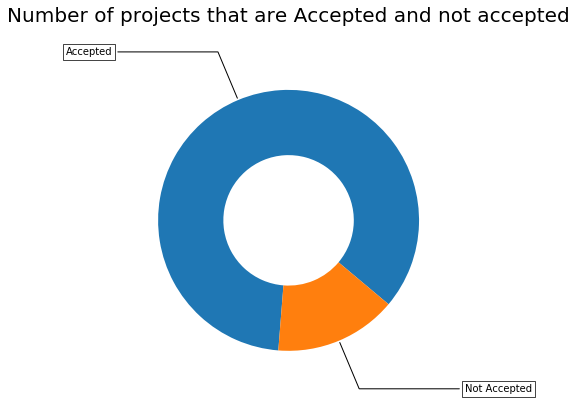

In [7]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = training_data['project_is_approved'].value_counts()
print("Number of projects that are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects that are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of projects that are Accepted and not accepted", fontsize=20,  y = 1.09)

plt.show()

### Summary

* 92706 projects were approved for funding out of 109248 applications i.e. 84.85 %
* 16542 projects were not approved for funding out of 109248 applications i.e. 15.14%
* Looks like an imbalanced dataset

In [8]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(training_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')


### Summary

* The plot shows all the 51 states of United States of America with rate of acceptance
* The shades of purple represents the percentage of acceptance
* The darker the shade the higher the acceptance percentage
* Delaware (DE) is the state with Most Acceptance percentage i.e. 89.79 %
* North Dakota (ND) is the state with Second most Acceptance percentage i.e. 88.81 %
* Washington (WA) is the state with Third most Acceptance percentage i.e. 87.61 %

In [9]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals\n")
print(temp.head(5))
print("\n\nStates with highest % approvals\n")
print(temp.tail(5))

States with lowest % approvals

   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245


States with highest % approvals

   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


### Summary

* Vermont state has the lowest percentage of acceptance i.e. 80.00 %
* Washington, D.C. has the second lowest percentage of acceptance i.e. 80.23 %
* Texas state has the third lowest percentage of acceptance i.e. 81.31 %
* Every state has greater than 80 % acceptance rate

In [10]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [11]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(training_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(training_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(training_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print('\n\n')
    print(temp.tail(5))
    print('\n')

# Univariate Analysis: school_state

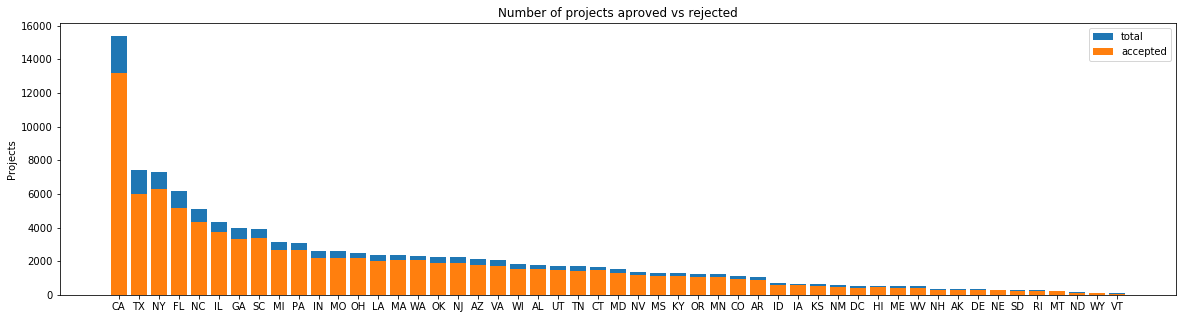

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038



   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000




In [12]:
univariate_barplots(training_data, 'school_state', 'project_is_approved', False)

### Summary

* California state has the most number of project submissions i.e. 15388
* Texas state has the second most number of project submissions i.e. 7396
* Wyoming state has the second least number of project submissions i.e. 98
* Vermont state has the least number of project submissions i.e. 80

# Univariate Analysis: teacher_prefix

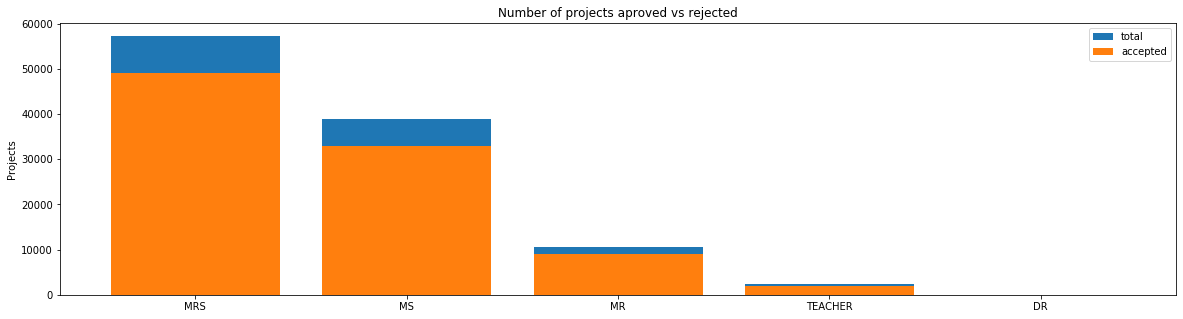

  teacher_prefix  project_is_approved  total       Avg
2            MRS                49000  57272  0.855566
3             MS                32860  38955  0.843537
1             MR                 8960  10648  0.841473
4        TEACHER                 1877   2360  0.795339
0             DR                    9     13  0.692308



  teacher_prefix  project_is_approved  total       Avg
2            MRS                49000  57272  0.855566
3             MS                32860  38955  0.843537
1             MR                 8960  10648  0.841473
4        TEACHER                 1877   2360  0.795339
0             DR                    9     13  0.692308




In [13]:
univariate_barplots(training_data, 'teacher_prefix', 'project_is_approved' , top=False)

### Summary

* MRS teacher_prefix has the most number of project submissions i.e. 57272 with 85.55 % acceptance rate
* MS teacher_prefix has the second most number of project submissions i.e. 38955 with 84.35 % acceptance rate
* Teacher teacher_prefix has the second least number of project submissions i.e. 2360 with 79.53 % acceptance rate
* DR teacher_prefix has the least number of project submissions i.e. 13 with 69.23 % acceptance rate

# Univariate Analysis: project_grade_category

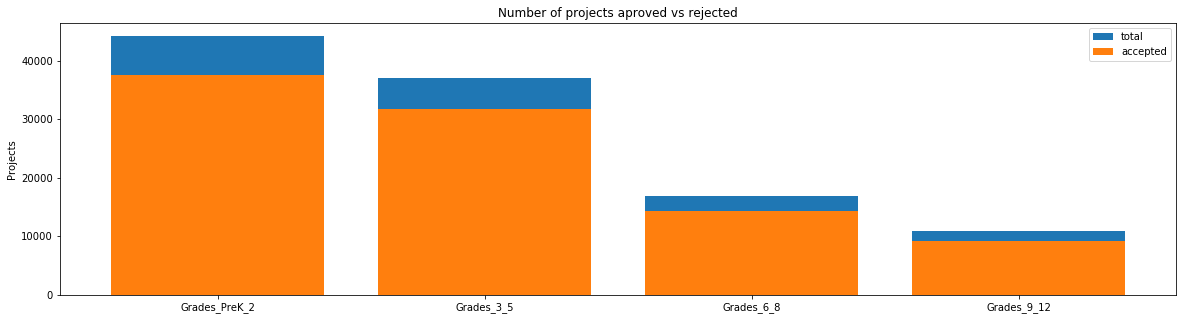

  project_grade_category  project_is_approved  total       Avg
3          Grades_PreK_2                37536  44225  0.848751
0             Grades_3_5                31729  37137  0.854377
1             Grades_6_8                14258  16923  0.842522
2            Grades_9_12                 9183  10963  0.837636



  project_grade_category  project_is_approved  total       Avg
3          Grades_PreK_2                37536  44225  0.848751
0             Grades_3_5                31729  37137  0.854377
1             Grades_6_8                14258  16923  0.842522
2            Grades_9_12                 9183  10963  0.837636




In [14]:
univariate_barplots(training_data, 'project_grade_category', 'project_is_approved', top=False)

### Summary

* Most number of projects are for Grades pre K - 2 i.e. 44225 with 84.87 % acceptance rate
* Second Most number of projects are for Grades 3-5 i.e. 37137 with 85.43 % acceptance rate
* Third Most number of projects are for Grades 6 - 8 i.e. 16923 with 84.25 % acceptance rate
* Least number of projects are for Grades 9 - 12 i.e. 10963 with 83.76 % acceptance rate

# Univariate Analysis: project_subject_categories

In [15]:
catogories = list(training_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [16]:
training_data['clean_categories'] = cat_list
training_data.drop(['project_subject_categories'], axis=1, inplace=True)
training_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            MRS   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             MR   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades_PreK_2   
1           FL        2016-10-25 09:22:10             Grades_6_8   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

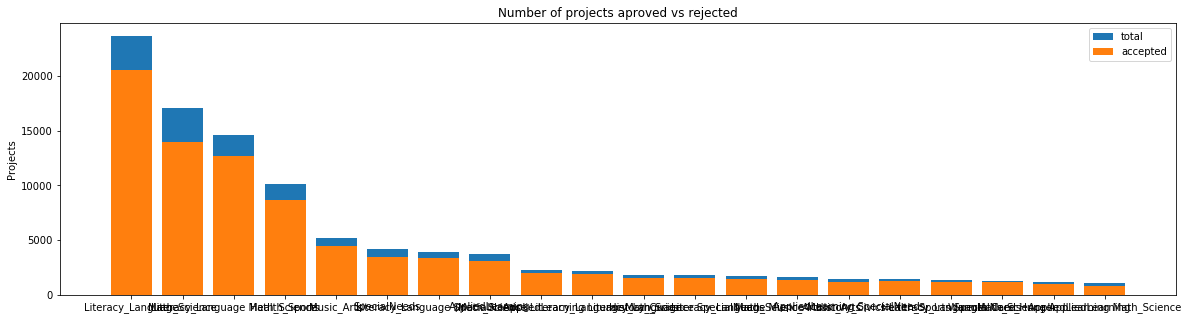

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019



                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738




In [17]:
univariate_barplots(training_data, 'clean_categories', 'project_is_approved', top=20)

### Summary

* Most number of projects are for Category Literacy & Language i.e. 23655 with 86.74 % acceptance rate
* Second Most number of projects are for Category Math & Science i.e. 17072 with 81.95 % acceptance rate
* Third Most number of projects are for Category Literacy, Language, Math & Science i.e. 14636 with 0.86.94 % acceptance rate
* Least number of projects are for Category AppliedLearning, Math & Science i.e. 1052 with 81.27 % acceptance rate

In [18]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in training_data['clean_categories'].values:
    my_counter.update(word.split())

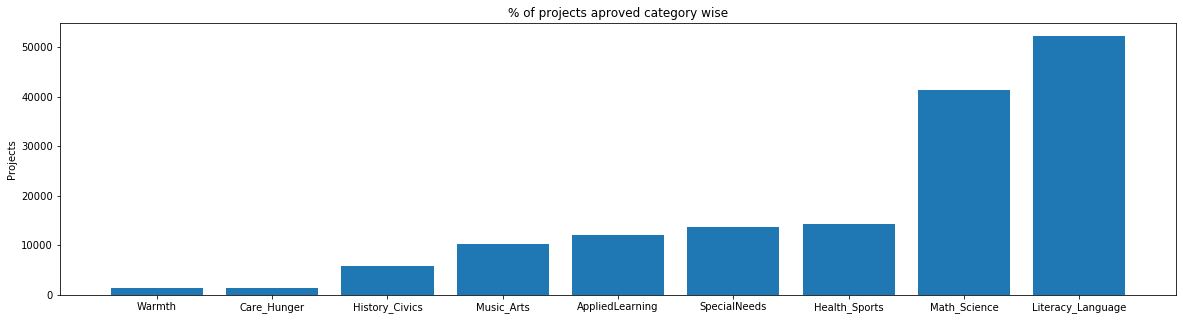

In [19]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [20]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [21]:
sub_catogories = list(training_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [22]:
training_data['clean_subcategories'] = sub_cat_list
training_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
training_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            MRS   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             MR   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades_PreK_2   
1           FL        2016-10-25 09:22:10             Grades_6_8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

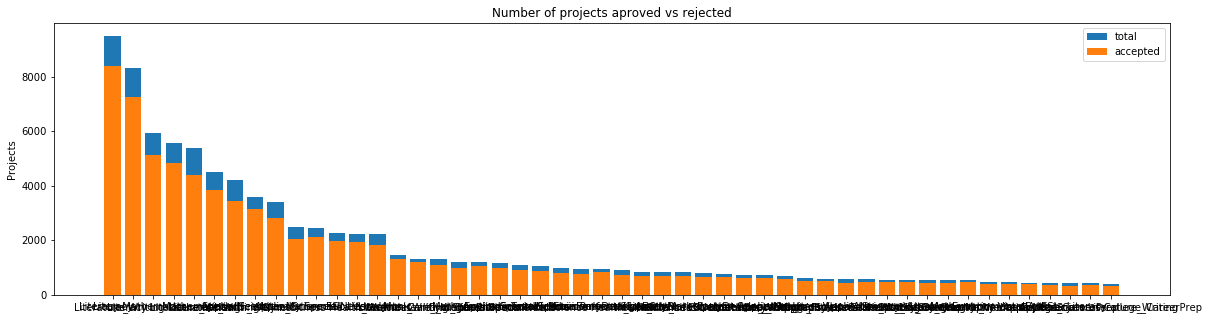

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207



                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815




In [23]:
univariate_barplots(training_data, 'clean_subcategories', 'project_is_approved', top=50)

### Summary

* Most number of projects are for Sub-Category Literacy i.e. 9486 with 88.2458 % acceptance rate
* Secomd Most number of projects are for Sub-Category Literacy & Mathematics i.e. 8325 with 87.2072 % acceptance rate
* Least number of projects are for Sub-Category AppliedSciences & College_CareerPrep i.e. 405 with 81.4815 % acceptance rate

In [24]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in training_data['clean_subcategories'].values:
    my_counter.update(word.split())

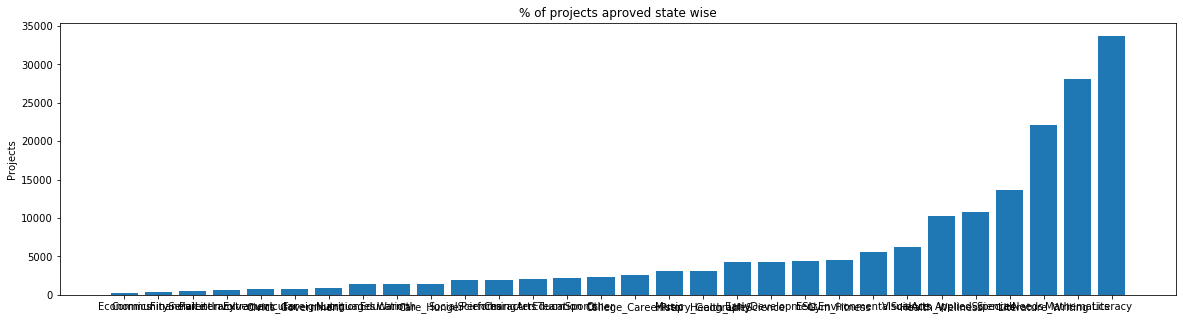

In [25]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [26]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


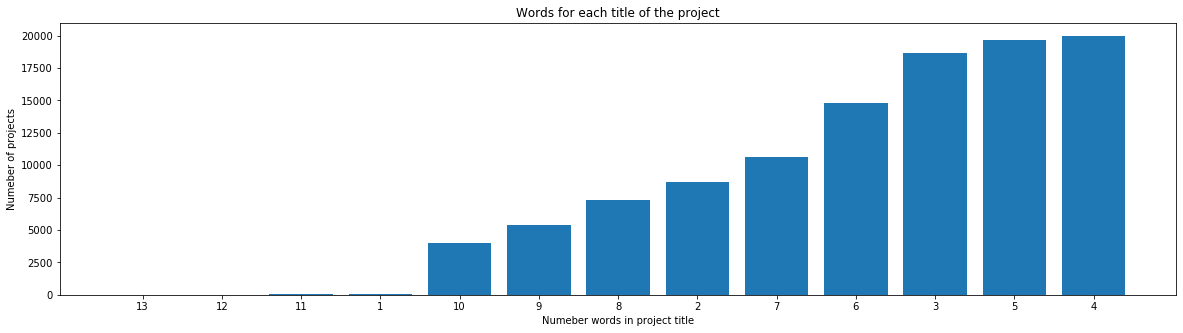

In [27]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = training_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [28]:
approved_title_word_count = training_data[training_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = training_data[training_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

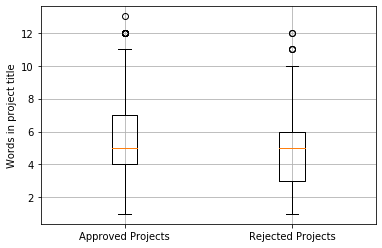

In [29]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

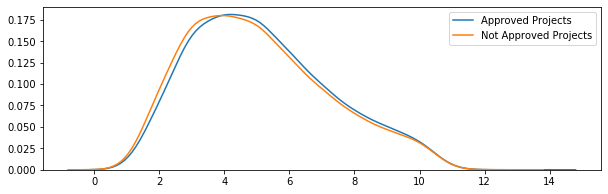

In [30]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

## Summary

* Most number of projects are accepted with 4 words in the title
* Second Most number of projects are accepted with 5 words in the title
* Third Most number of projects are accepted with 3 words in the title
* Least number of projects are accepted with 13 words in the title

# 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [31]:
# merge two column text dataframe: 
training_data["essay"] = training_data["project_essay_1"].map(str) +\
                        training_data["project_essay_2"].map(str) + \
                        training_data["project_essay_3"].map(str) + \
                        training_data["project_essay_4"].map(str)

In [32]:
approved_word_count = training_data[training_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = training_data[training_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

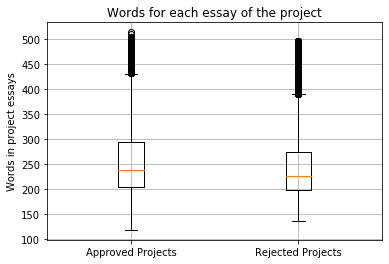

In [33]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

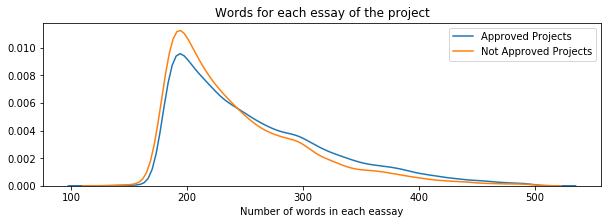

In [34]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

## Summary

* More than 50 % of accepted projects have less than 250 words in their essays
* More than 50 % of rejected projects have less than 250 words in their essays
* More than 75 % of accepted projects have less than 300 words in their essays
* More than 75 % of rejected projects have less than 300 words in their essays

# 1.2.8 Univariate Analysis: Cost per project

In [35]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [36]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [37]:
# join two dataframes in python: 
training_data = pd.merge(training_data, price_data, on='id', how='left')

In [38]:
approved_price = training_data[training_data['project_is_approved']==1]['price'].values

rejected_price = training_data[training_data['project_is_approved']==0]['price'].values

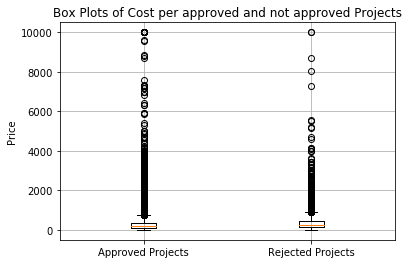

In [39]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

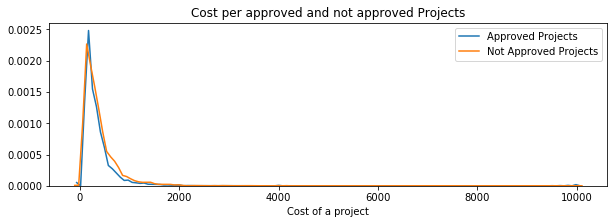

In [40]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [41]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

### Summary

* All the projects prices are between 0.66 to 9999.0
* 50 % of accepted project prices are under 198.99
* 50 % of rejected project prices are under 263.145
* Accepted project prices are less when compared to rejected projects prices

# Univariate Analysis: teacher_number_of_previously_posted_projects

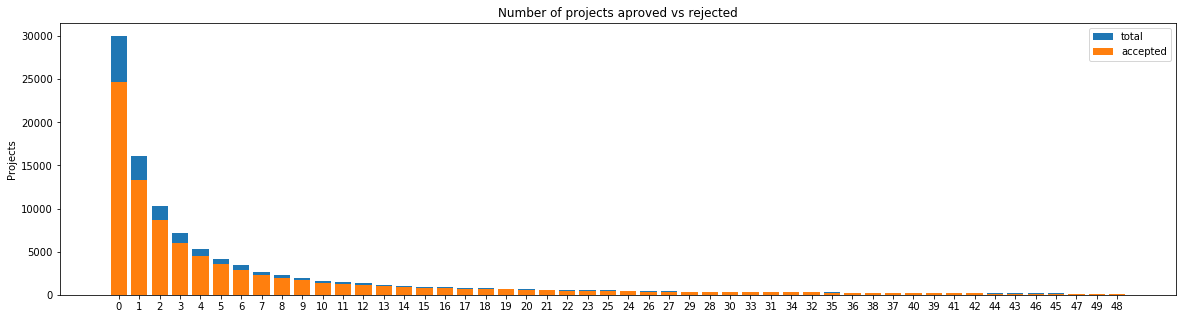

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  



    teacher_number_of_previously_posted_projects  project_is_approved  total  \
46                                            46                  149    164   
45                                            45                  141    153   
47                                            47                  129    144   
49                                            49                  128    143   
48                                    

In [42]:
univariate_barplots(training_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top=50)

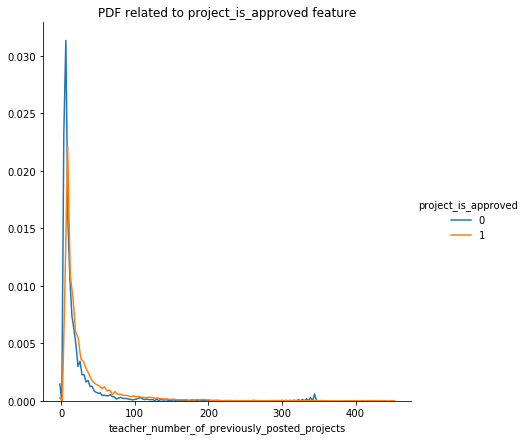

In [43]:
sns.FacetGrid(training_data, hue = 'project_is_approved', height = 6).map(sns.distplot,
                                            'teacher_number_of_previously_posted_projects', hist = False).add_legend()
plt.title('PDF related to project_is_approved feature')
plt.show()

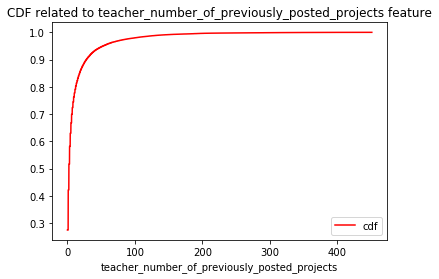

451

In [44]:
number_of_Points, bin_edges = np.histogram(training_data['teacher_number_of_previously_posted_projects'],
                                bins = 109248, density='True')

pdf = number_of_Points/sum(number_of_Points)
cdf = np.cumsum(pdf)
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.plot(bin_edges[1:], cdf, 'r-', label = 'cdf')

plt.title('CDF related to teacher_number_of_previously_posted_projects feature')
plt.legend()
plt.show()
training_data['teacher_number_of_previously_posted_projects'].max()

### Summary

* 27.46 % of teachers have posted the projects for the first time
* The first timers have posted 30014 projects with 82.13 % acceptance rate
* The maximum number of projects posted by any teacher is 451

## project_resource_summary

In [45]:
training_data.project_resource_summary.head(20).get

<bound method NDFrame.get of 0     My students need opportunities to practice beg...
1     My students need a projector to help with view...
2     My students need shine guards, athletic socks,...
3     My students need to engage in Reading and Math...
4     My students need hands on practice in mathemat...
5     My students need movement to be successful. Be...
6     My students need some dependable laptops for d...
7     My students need ipads to help them access a w...
8     My students need three devices and three manag...
9     My students need great books to use during Ind...
10    My students need books by their favorite autho...
11    My students need paper, three chromebooks, and...
12    My students need 3D and 4D life science activi...
13    My students need access to technology that wil...
14    My students need 5 tablets for our classroom t...
15    My students need activities to play during rec...
16    My students need 2 LeapPad that will engage th...
17    My students n

In [46]:
summary_list = list(training_data['project_resource_summary'].values)

project_resource_summary_list = []
for i in summary_list:
    if re.search('\d',  i):
        project_resource_summary_list.append(1)
    else:
        project_resource_summary_list.append(0)

In [47]:
training_data['project_resource_summary_with_digits'] = project_resource_summary_list
training_data.head(20)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0       160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            MRS   
1       140945  p258326  897464ce9ddc600bced1151f324dd63a             MR   
2        21895  p182444  3465aaf82da834c0582ebd0ef8040ca0             MS   
3           45  p246581  f3cb9bffbba169bef1a77b243e620b60            MRS   
4       172407  p104768  be1f7507a41f8479dc06f047086a39ec            MRS   
5       141660  p154343  a50a390e8327a95b77b9e495b58b9a6e            MRS   
6        21147  p099819  9b40170bfa65e399981717ee8731efc3            MRS   
7        94142  p092424  5bfd3d12fae3d2fe88684bbac570c9d2             MS   
8       112489  p045029  487448f5226005d08d36bdd75f095b31            MRS   
9       158561  p001713  140eeac1885c820ad5592a409a3a8994             MS   
10       43184  p040307  363788b51d40d978fe276bcb1f8a2b35            MRS   
11      127083  p251806  4ba7c721133ef651ca54a03551746708             MS   
12       19090  p051126  5e52c92b7e3c472aad247a239d345543            MRS   
13       15126  p003874  178f6ae765cd4e0fb143a77c47fd65e2            MRS   
14       62232  p233127  424819801de22a60bba7d0f4354d0258             MS   
15       67303  p132832  bb6d6d054824fa01576ab38dfa2be160             MS   
16      127215  p174627  4ad7e280fddff889e1355cc9f29c3b89            MRS   
17      157771  p152491  e39abda057354c979c5b075cffbe5f88             MS   
18      122186  p196421  fcd9b003fc1891383f340a89da02a1a6            MRS   
19      146331  p058343  8e07a98deb1bc74c75b97521e05b1691             MS   

   school_state project_submitted_datetime project_grade_category  \
0            IN        2016-12-05 13:43:57          Grades_PreK_2   
1            FL        2016-10-25 09:22:10             Grades_6_8   
2            AZ        2016-08-31 12:03:56             Grades_6_8   
3            KY        2016-10-06 21:16:17          Grades_PreK_2   
4            TX        2016-07-11 01:10:09          Grades_PreK_2   
5            FL        2017-04-08 22:40:43             Grades_3_5   
6            CT        2017-02-17 19:58:56             Grades_6_8   
7            GA        2016-09-01 00:02:15             Grades_3_5   
8            SC        2016-09-25 17:00:26          Grades_PreK_2   
9            NC        2016-11-17 18:18:56          Grades_PreK_2   
10           CA        2017-01-04 16:40:30             Grades_3_5   
11           CA        2016-11-14 22:57:28          Grades_PreK_2   
12           NY        2016-05-23 15:46:02             Grades_6_8   
13           OK        2016-10-17 09:49:27          Grades_PreK_2   
14           MA        2017-02-14 16:29:10          Grades_PreK_2   
15           TX        2016-10-05 21:05:38             Grades_3_5   
16           FL        2017-01-18 10:59:05          Grades_PreK_2   
17           NV        2016-11-23 17:14:17             Grades_3_5   
18           GA        2016-08-28 15:04:42          Grades_PreK_2   
19           OH        2016-08-06 13:05:20             Grades_3_5   

                                        project_title  \
0    Educational Support for English Learners at Home   
1               Wanted: Projector for Hungry Learners   
2   Soccer Equipment for AWESOME Middle School Stu...   
3                              Techie Kindergarteners   
4                              Interactive Math Tools   
5   Flexible Seating for Mrs. Jarvis' Terrific Thi...   
6   Chromebooks for Special Education Reading Program   
7                               It's the 21st Century   
8                     Targeting More Success in Class   
9     Just For the Love of Reading--\r\nPure Pleasure   
10                              Reading Changes Lives   
11  Elevating Academics and Parent Rapports Throug...   
12                  Building Life Science Experiences   
13                     Everyone deserves to be heard!   
14                      TABLETS CAN SHOW US THE WORLD   
15                               Making Reces

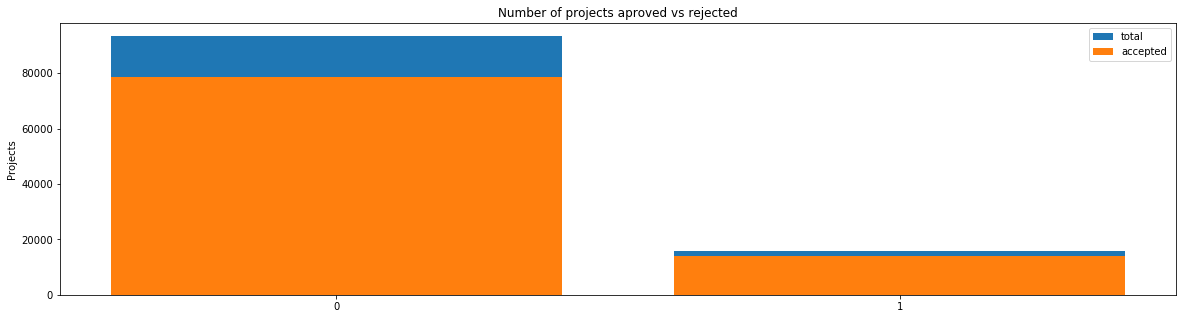

   project_resource_summary_with_digits  project_is_approved  total       Avg
0                                     0                78616  93492  0.840885
1                                     1                14090  15756  0.894263



   project_resource_summary_with_digits  project_is_approved  total       Avg
0                                     0                78616  93492  0.840885
1                                     1                14090  15756  0.894263




In [48]:
univariate_barplots(training_data, 'project_resource_summary_with_digits', 'project_is_approved', top=50)

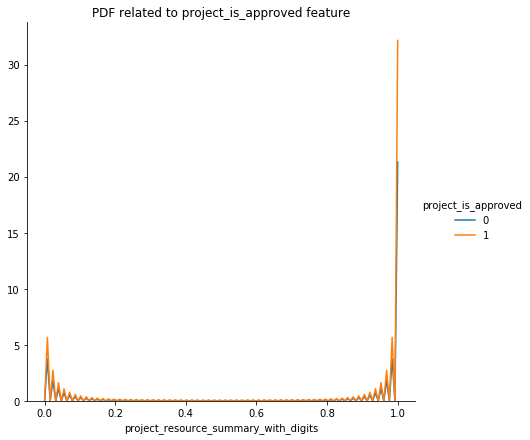

In [49]:
sns.FacetGrid(training_data, hue = 'project_is_approved', height = 6).map(sns.distplot,
                                            'project_resource_summary_with_digits', hist = False).add_legend()
plt.title('PDF related to project_is_approved feature')
plt.show()

In [50]:
training_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            MRS   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             MR   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades_PreK_2   
1           FL        2016-10-25 09:22:10             Grades_6_8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... project_essay_4  \
0  \"The limits of your language are the limits o...  ...             NaN   
1  The projector we need for our school is very c...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            0                    0   
1                                            7                    1   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

                                               essay  price  quantity  \
0  My students are English learners that are work...  154.6        23   
1  Our students arrive to our school eager to lea...  299.0         1   

   project_resource_summary_with_digits  
0                                     0  
1                                     0  

[2 rows x 21 columns]

### Summary

* 93492 projects were submitted without any digits in their essays with 84.0885 % acceptance ratio
* 15756 projects were submitted without any digits in their essays with 89.4263 % acceptance ratio
* Projects with digits in their essays have 5.33 % more acceptance ratio than projects without digits

In [51]:
# printing some random essays.
print(training_data['essay'].values[0])
print("\n\n")
print(training_data['essay'].values[150])
print("\n\n")
print(training_data['essay'].values[1000])
print("\n\n")
print(training_data['essay'].values[20000])
print("\n\n")
print(training_data['essay'].values[99999])
print("\n\n")


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [52]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [53]:
formatted_essay = decontracted(training_data['essay'].values[20000])
print(formatted_essay)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [54]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
formatted_essay = formatted_essay.replace('\\r', ' ')
formatted_essay = formatted_essay.replace('\\"', ' ')
formatted_essay = formatted_essay.replace('\\n', ' ')
print(formatted_essay)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [55]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
formatted_essay = re.sub('[^A-Za-z0-9]+', ' ', formatted_essay)
print(formatted_essay)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [56]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [57]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(training_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:53<00:00, 2055.54it/s]


In [58]:
# after preprocesing
print(len(preprocessed_essays))

109248


In [59]:
training_data.head(30)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0       160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            MRS   
1       140945  p258326  897464ce9ddc600bced1151f324dd63a             MR   
2        21895  p182444  3465aaf82da834c0582ebd0ef8040ca0             MS   
3           45  p246581  f3cb9bffbba169bef1a77b243e620b60            MRS   
4       172407  p104768  be1f7507a41f8479dc06f047086a39ec            MRS   
5       141660  p154343  a50a390e8327a95b77b9e495b58b9a6e            MRS   
6        21147  p099819  9b40170bfa65e399981717ee8731efc3            MRS   
7        94142  p092424  5bfd3d12fae3d2fe88684bbac570c9d2             MS   
8       112489  p045029  487448f5226005d08d36bdd75f095b31            MRS   
9       158561  p001713  140eeac1885c820ad5592a409a3a8994             MS   
10       43184  p040307  363788b51d40d978fe276bcb1f8a2b35            MRS   
11      127083  p251806  4ba7c721133ef651ca54a03551746708             MS   
12       19090  p051126  5e52c92b7e3c472aad247a239d345543            MRS   
13       15126  p003874  178f6ae765cd4e0fb143a77c47fd65e2            MRS   
14       62232  p233127  424819801de22a60bba7d0f4354d0258             MS   
15       67303  p132832  bb6d6d054824fa01576ab38dfa2be160             MS   
16      127215  p174627  4ad7e280fddff889e1355cc9f29c3b89            MRS   
17      157771  p152491  e39abda057354c979c5b075cffbe5f88             MS   
18      122186  p196421  fcd9b003fc1891383f340a89da02a1a6            MRS   
19      146331  p058343  8e07a98deb1bc74c75b97521e05b1691             MS   
20       75560  p052326  e0c1aad1f71badeff703fadc15f57680            MRS   
21      132078  p187097  2d4a4d2d774e5c2fdd25b2ba0e7341f8            MRS   
22       84810  p165540  30f08fbe02eba5453c4ce2e857e88eb4             MS   
23        8636  p219330  258ef2e6ab5ce007ac6764ce15d261ba             MR   
24       21478  p126524  74f8690562c44fc88f65f845b9fe61d0            MRS   
25       20142  p009037  b8bf3507cee960d5fedcb27719df2d59            MRS   
26       33903  p040091  7a0a5de5ed94e7036946b1ac3eaa99d0             MS   
27        1156  p161033  efdc3cf14d136473c9f62becc00d4cec        TEACHER   
28       35430  p085706  22c8184c4660f1c589bea061d14b7f35            MRS   
29       22088  p032018  45f16a103f1e00b7439861d4e0728a59            MRS   

   school_state project_submitted_datetime project_grade_category  \
0            IN        2016-12-05 13:43:57          Grades_PreK_2   
1            FL        2016-10-25 09:22:10             Grades_6_8   
2            AZ        2016-08-31 12:03:56             Grades_6_8   
3            KY        2016-10-06 21:16:17          Grades_PreK_2   
4            TX        2016-07-11 01:10:09          Grades_PreK_2   
5            FL        2017-04-08 22:40:43             Grades_3_5   
6            CT        2017-02-17 19:58:56             Grades_6_8   
7            GA        2016-09-01 00:02:15             Grades_3_5   
8            SC        2016-09-25 17:00:26          Grades_PreK_2   
9            NC        2016-11-17 18:18:56          Grades_PreK_2   
10           CA        2017-01-04 16:40:30             Grades_3_5   
11           CA        2016-11-14 22:57:28          Grades_PreK_2   
12           NY        2016-05-23 15:46:02             Grades_6_8   
13           OK        2016-10-17 09:49:27          Grades_PreK_2   
14           MA        2017-02-14 16:29:10          Grades_PreK_2   
15           TX        2016-10-05 21:05:38             Grades_3_5   
16           FL        2017-01-18 10:59:05          Grades_PreK_2   
17           NV        2016-11-23 17:14:17             Grades_3_5   
18           GA        2016-08-28 15:04:42          Grades_PreK_2   
19           OH        2016-08-06 13:05:20             Grades_3_5   
20           PA        2016-10-07 18:27:02          Grades_PreK_2   
21           NC        2016-05-17 19:45:13             Grades_6_8   
22           CA        2016-09-01 10:09:15            Grades

In [60]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(training_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:02<00:00, 44584.12it/s]


In [61]:
print(preprocessed_titles[20000],'\n\n')

print(preprocessed_essays[20000])

training_data.values[20000]

we need to move it while we input it 


my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan


array([65303, 'p115814', 'ffa0035d53b0c5379720954131051f60', 'MRS', 'NJ',
       '2016-08-11 09:06:14', 'Grades_PreK_2',
       'We Need To Move It While We Input It!',
       'My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \\r\\n\\r\\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.',
       "Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which

# Preparing data for models

In [62]:
training_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'project_resource_summary_with_digits'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

# Vectorizing Categorical data

In [63]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(training_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(training_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


In [64]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(training_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(training_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)


['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


In [65]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
state_counter = Counter()
for word in training_data['school_state'].values:
    state_counter.update(word.split())

In [66]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
school_state_dict = dict(state_counter)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))

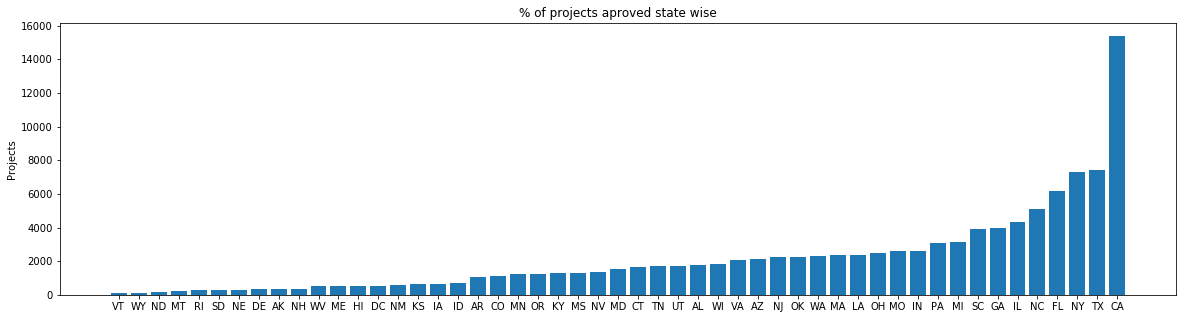

In [67]:
ind = np.arange(len(sorted_school_state_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_school_state_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_school_state_dict.keys()))
plt.show()

In [68]:
for i, j in sorted_school_state_dict.items():
    print("{:20} :{:10}".format(i,j))

VT                   :        80
WY                   :        98
ND                   :       143
MT                   :       245
RI                   :       285
SD                   :       300
NE                   :       309
DE                   :       343
AK                   :       345
NH                   :       348
WV                   :       503
ME                   :       505
HI                   :       507
DC                   :       516
NM                   :       557
KS                   :       634
IA                   :       666
ID                   :       693
AR                   :      1049
CO                   :      1111
MN                   :      1208
OR                   :      1242
KY                   :      1304
MS                   :      1323
NV                   :      1367
MD                   :      1514
CT                   :      1663
TN                   :      1688
UT                   :      1731
AL                   :      1762
WI        

In [69]:
vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(training_data['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot = vectorizer.transform(training_data['school_state'].values)
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)


['VT', 'WY', 'ND', 'MT', 'RI', 'SD', 'NE', 'DE', 'AK', 'NH', 'WV', 'ME', 'HI', 'DC', 'NM', 'KS', 'IA', 'ID', 'AR', 'CO', 'MN', 'OR', 'KY', 'MS', 'NV', 'MD', 'CT', 'TN', 'UT', 'AL', 'WI', 'VA', 'AZ', 'NJ', 'OK', 'WA', 'MA', 'LA', 'OH', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix after one hot encodig  (109248, 51)


# Vectorizing teacher_prefix

In [70]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
teacher_prefix_counter = Counter()
for word in training_data['teacher_prefix'].values:
    teacher_prefix_counter.update(word.split())

In [71]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
teacher_prefix_dict = dict(teacher_prefix_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))

In [72]:
for i, j in sorted_teacher_prefix_dict.items():
    print("{:20} :{:10}".format(i,j))

DR                   :        13
TEACHER              :      2360
MR                   :     10648
MS                   :     38955
MRS                  :     57272


In [73]:
vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(training_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(training_data['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)


['DR', 'TEACHER', 'MR', 'MS', 'MRS']
Shape of matrix after one hot encodig  (109248, 5)


# Vectorizing project_grade_category

In [74]:
project_grade_counter = Counter()
for word in training_data['project_grade_category'].values:
    project_grade_counter.update(word.split())

In [75]:
project_grade_dict = dict(project_grade_counter)
sorted_project_grade_dict = dict(sorted(project_grade_dict.items(), key=lambda kv: kv[1]))

In [76]:
for i, j in sorted_project_grade_dict.items():
    print("{:20} :{:10}".format(i,j))

Grades_9_12          :     10963
Grades_6_8           :     16923
Grades_3_5           :     37137
Grades_PreK_2        :     44225


In [77]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(training_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grade_category_one_hot = vectorizer.transform(training_data['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",project_grade_category_one_hot.shape)


['Grades_9_12', 'Grades_6_8', 'Grades_3_5', 'Grades_PreK_2']
Shape of matrix after one hot encodig  (109248, 4)


## Vectorizing Text data

# 1.4.2.1

In [78]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
essays_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",essays_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [79]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
titles_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_bow.shape)

Shape of matrix after one hot encodig  (109248, 3329)


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
essays_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",essays_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 3329)


In [82]:
'''# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

'''

'# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n'

In [83]:
'''words = []
for i in preprocessed_essays:
    words.extend(i.split(' '))

for i in preprocessed_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))'''

'words = []\nfor i in preprocessed_essays:\n    words.extend(i.split(\' \'))\n\nfor i in preprocessed_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(words)\nprint("The number of words that are present in both glove vectors and our coupus",       len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")\n\nwords_courpus = {}\nwords_glove = set(model.keys())\nfor i in words:\n    if i in words_glove:\n        words_courpus[i] = model[i]\nprint("word 2 vec length", len(words_courpus))'

In [84]:
'''# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)
'''

"# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/\n\nimport pickle\nwith open('glove_vectors', 'wb') as f:\n    pickle.dump(words_courpus, f)\n"

In [85]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [86]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:26<00:00, 4056.67it/s]

109248
300


In [87]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles.append(vector)

print(len(avg_w2v_vectors_titles))
print(len(avg_w2v_vectors_titles[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:01<00:00, 81507.06it/s]

109248
300


# Using Pretrained Models: TFIDF weighted W2V

In [88]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [89]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [03:26<00:00, 527.78it/s]

109248
300


In [90]:
tfidf_model_titles = TfidfVectorizer()
tfidf_model_titles.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model_titles.get_feature_names(), list(tfidf_model_titles.idf_)))
tfidf_words_titles = set(tfidf_model_titles.get_feature_names())

In [91]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles.append(vector)

print(len(tfidf_w2v_vectors_titles))
print(len(tfidf_w2v_vectors_titles[0]))

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:03<00:00, 35703.71it/s]

109248
300


In [92]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(training_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(training_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [93]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

teacher_noppp_scalar = StandardScaler()
teacher_noppp_scalar.fit(training_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {teacher_noppp_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
teacher_noppp_standardized = teacher_noppp_scalar.transform(training_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.153165275336848, Standard deviation : 367.49634838483496


# Merging all the above features

In [94]:
print('School State ',school_state_one_hot.shape)
print('Teacher Prefix ',teacher_prefix_one_hot.shape)
print('Project Grade ',project_grade_category_one_hot.shape)
print('Title ',titles_bow.shape)
print('Essay ',essays_bow.shape)
print('Categories ',categories_one_hot.shape)
print('Sub Categories',sub_categories_one_hot.shape)
print('Price',price_standardized.shape)
print('Teacher number of previously posted projects',teacher_noppp_standardized.shape)

School State  (109248, 51)
Teacher Prefix  (109248, 5)
Project Grade  (109248, 4)
Title  (109248, 3329)
Essay  (109248, 16623)
Categories  (109248, 9)
Sub Categories (109248, 30)
Price (109248, 1)
Teacher number of previously posted projects (109248, 1)


In [95]:
print('Title BOW',titles_bow.shape)
print('Essay BOW',essays_bow.shape)
print('Title TFIDF',titles_tfidf.shape)
print('Essay TFIDF',essays_tfidf.shape)
print('Title AVG W2V (',len(avg_w2v_vectors_titles),',',len(avg_w2v_vectors_titles[0]),')')
print('Essay AVG W2V (',len(avg_w2v_vectors),',',len(avg_w2v_vectors[0]),')')
print('Title TFIDF AVG W2V (',len(tfidf_w2v_vectors_titles),',',len(tfidf_w2v_vectors_titles[0]),')')
print('Essay TFIDF AVG W2V (',len(tfidf_w2v_vectors),',',len(tfidf_w2v_vectors[0]),')')

Title BOW (109248, 3329)
Essay BOW (109248, 16623)
Title TFIDF (109248, 3329)
Essay TFIDF (109248, 16623)
Title AVG W2V ( 109248 , 300 )
Essay AVG W2V ( 109248 , 300 )
Title TFIDF AVG W2V ( 109248 , 300 )
Essay TFIDF AVG W2V ( 109248 , 300 )


In [96]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_BOW = hstack((school_state_one_hot, teacher_prefix_one_hot, project_grade_category_one_hot, 
            categories_one_hot, sub_categories_one_hot, price_standardized, 
            teacher_noppp_standardized, titles_bow)).tocsr()
X_BOW.shape

(109248, 3430)

In [97]:
X_BOW_5000 = X_BOW[0:5000,:]
X_BOW_5000.shape

(5000, 3430)

In [98]:
X_BOW_1000 = X_BOW[0:1000,:]
X_BOW_1000.shape

(1000, 3430)

In [99]:
X_BOW_10000 = X_BOW[0:10000,:]
X_BOW_10000.shape

(10000, 3430)

In [100]:
labels = training_data['project_is_approved']
labels.shape

(109248,)

In [101]:
labels_1000 = labels[0: 1000]
labels_1000.shape

(1000,)

In [102]:
labels_5000 = labels[0: 5000]
labels_5000.shape

(5000,)

In [103]:
labels_10000 = labels[0: 10000]
labels_10000.shape

(10000,)

## 2.1 TSNE with 'BOW' encoding of 'project_title' feature

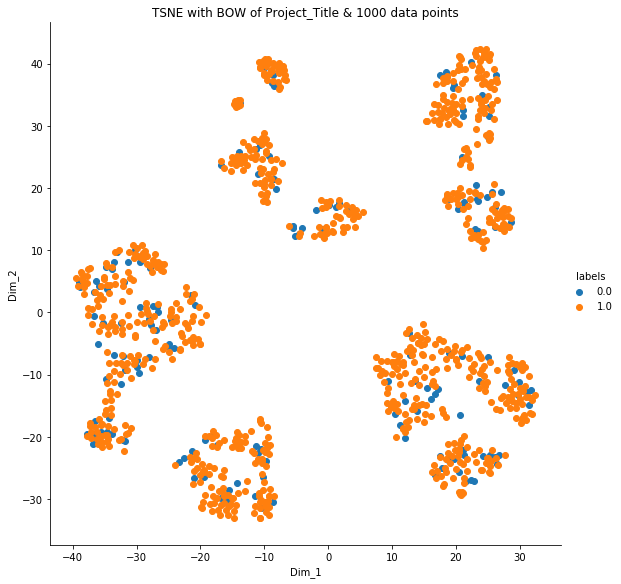

In [104]:

from sklearn.manifold import TSNE

x = X_BOW_1000
y = labels_1000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())
tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with BOW of Project_Title & 1000 data points')
plt.show()

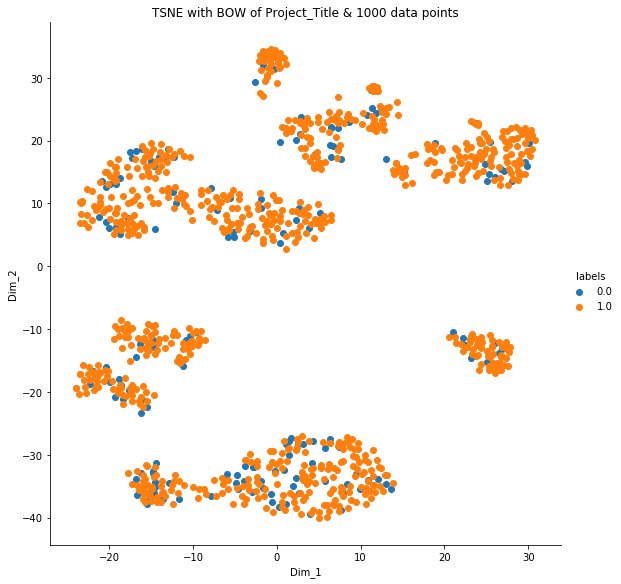

In [105]:

from sklearn.manifold import TSNE

x = X_BOW_1000
y = labels_1000

model = TSNE(n_components=2, perplexity=40, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())
tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with BOW of Project_Title & 1000 data points')
plt.show()

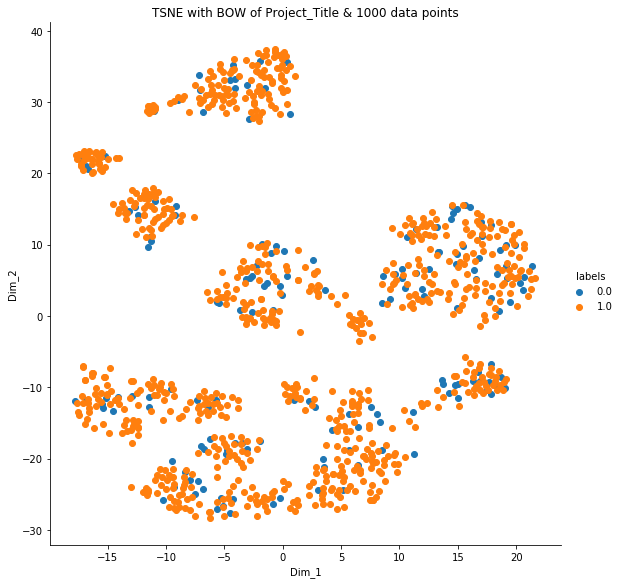

In [106]:

from sklearn.manifold import TSNE

x = X_BOW_1000
y = labels_1000

model = TSNE(n_components=2, perplexity=50, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())
tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with BOW of Project_Title & 1000 data points')
plt.show()

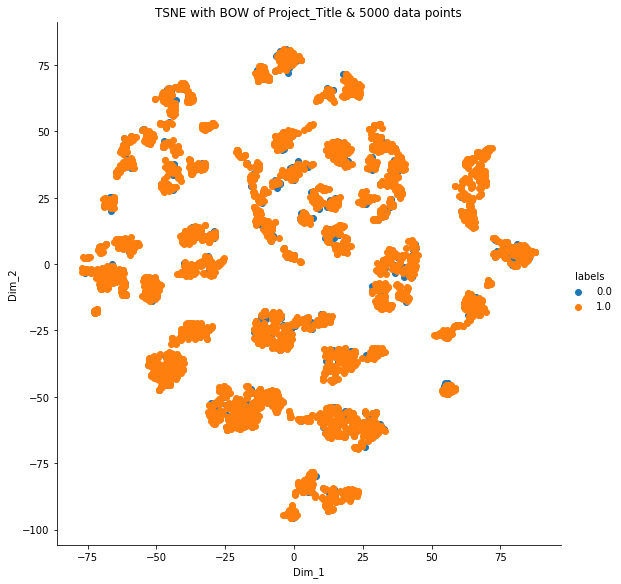

In [107]:
# TSNE with 5000 data points

X_BOW_1000 = X_BOW[0:1000,:]
X_BOW_1000.shape

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
x = X_BOW_5000
y = labels_5000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with BOW of Project_Title & 5000 data points')
plt.show()

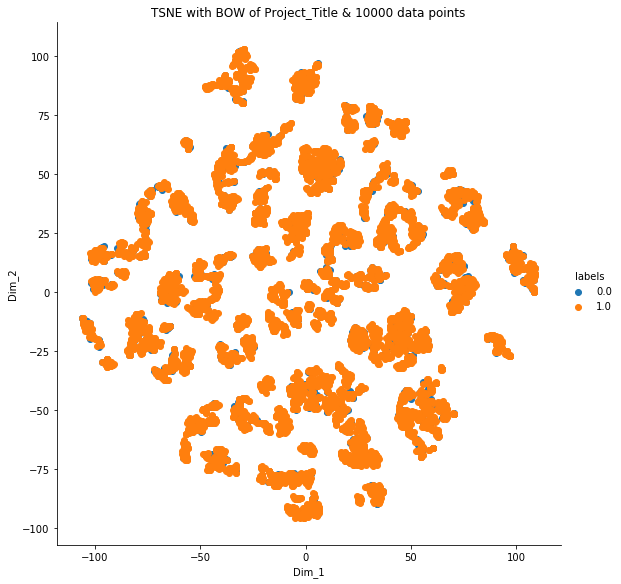

In [108]:
# TSNE with 10000 data points

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
x = X_BOW_10000
y = labels_10000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with BOW of Project_Title & 10000 data points')
plt.show()

### Summary

* Vectorized categorical and numerical features and stacked it with title BOW vector 
* Plotted TSNE with different Perplexity and Random_State values for 1000 data points
* After experimenting with different combinations, choosed the final values of perplexity and
    random_state as 30 and 300 respectively.
* Plotted TSNE with all categorical, numerical features and Title BOW vector for 1K, 5K and 10K data points
* Observed that the accepted projects are more than the rejected projects.
* Accepted and Rejected classes are heavily overlaping and not seperated at this point

## 2.2 TSNE with 'TFIDF' encoding of 'project_title' feature 

In [109]:

X_TFIDF = hstack((school_state_one_hot, teacher_prefix_one_hot, project_grade_category_one_hot, 
            categories_one_hot, sub_categories_one_hot, price_standardized, 
            teacher_noppp_standardized, titles_tfidf)).tocsr()

X_TFIDF_5000 = X_TFIDF[0:5000,:]
X_TFIDF_10000 = X_TFIDF[0:10000,:]

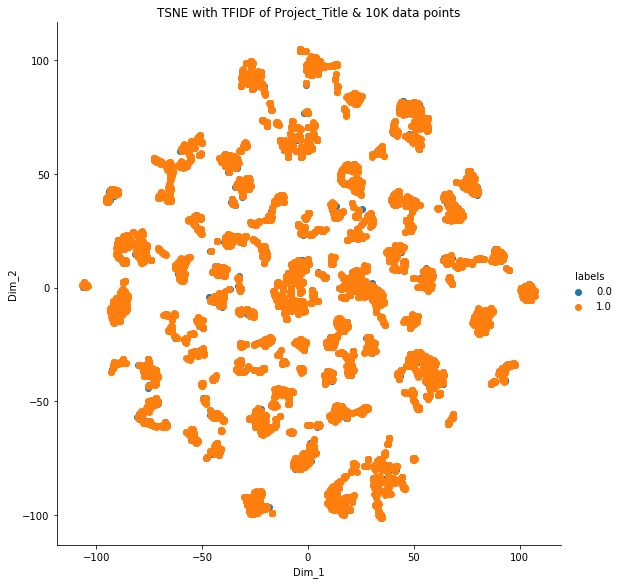

In [110]:

from sklearn.manifold import TSNE

x = X_TFIDF_10000
y = labels_10000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())

tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with TFIDF of Project_Title & 10K data points')
plt.show()

### Summary

* Plotted TSNE with all categorical, numerical features and Title TFIDF vector for 10K data points
* Observed that the accepted projects are more than the rejected projects.
* Accepted and Rejected classes are heavily overlaping and not seperated at this point
* Didn't find any major difference when compared to TSNE BOW title vector

## 2.3 TSNE with 'AVG W2V' encoding of 'project_title' feature

In [111]:

X_AVG_W2V = hstack((school_state_one_hot, teacher_prefix_one_hot, project_grade_category_one_hot, 
            categories_one_hot, sub_categories_one_hot, price_standardized, 
            teacher_noppp_standardized, avg_w2v_vectors_titles)).tocsr()

X_AVG_W2V_10000 = X_AVG_W2V[0:10000,:]


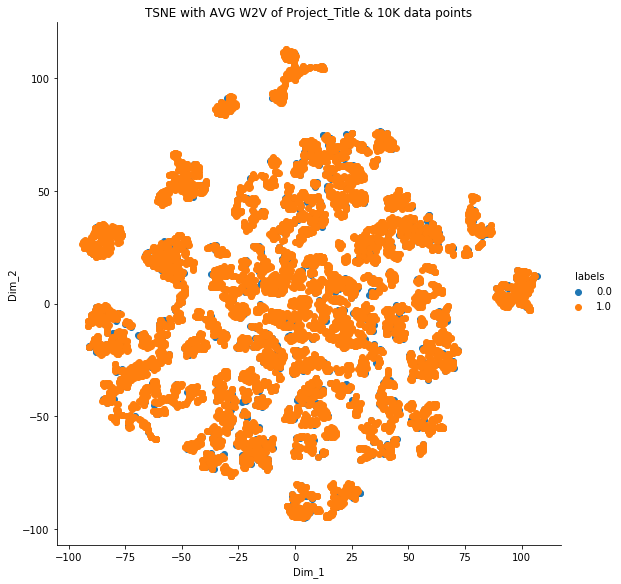

In [112]:

from sklearn.manifold import TSNE

x = X_AVG_W2V_10000
y = labels_10000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())

tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with AVG W2V of Project_Title & 10K data points')
plt.show()

### Summary

* Plotted TSNE with all categorical and numerical features and Title AVG W2V vector for 10K data points
* Observed that the accepted projects are more than the rejected projects.
* Accepted and Rejected classes are heavily overlaping and not seperated at this point
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors

## 2.4 TSNE with 'TFIDF Weighted W2V' encoding of 'project_title' feature

In [113]:

X_TFIDF_W2V = hstack((school_state_one_hot, teacher_prefix_one_hot, project_grade_category_one_hot, 
            categories_one_hot, sub_categories_one_hot, price_standardized, 
            teacher_noppp_standardized, tfidf_w2v_vectors_titles)).tocsr()

X_TFIDF_W2V_10000 = X_TFIDF_W2V[0:10000,:]


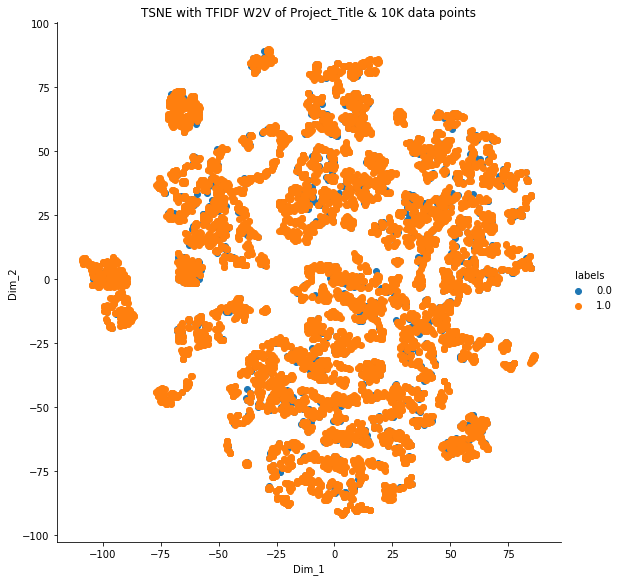

In [114]:

from sklearn.manifold import TSNE

x = X_TFIDF_W2V_10000
y = labels_10000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())

tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with TFIDF W2V of Project_Title & 10K data points')
plt.show()

### Summary

* Plotted TSNE with all categorical and numerical features and Title TFIDF W2V vector for 10K data points
* Observed that the accepted projects are more than the rejected projects.
* Accepted and Rejected classes are heavily overlaping and not seperated at this point
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors, but no major difference when compared to TSNE of AVG W2V Title vector

## 2.4.1 TSNE with 'TFIDF Weighted W2V' encoding of 'project_title' and  'project_essay' features (Extra)

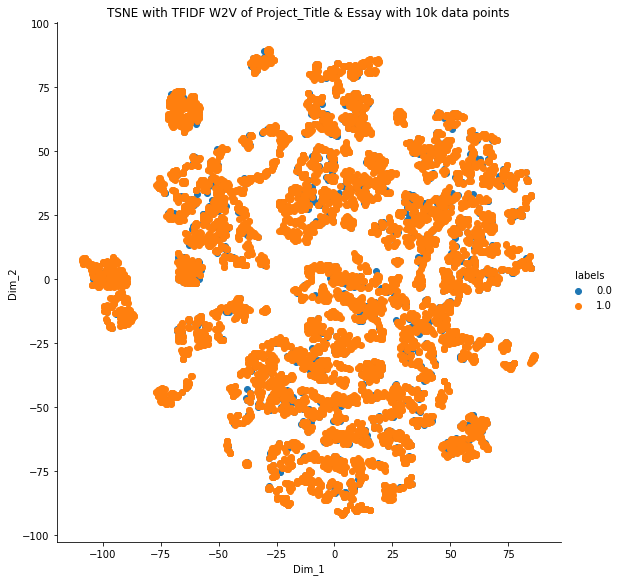

In [115]:

X_TFIDF_W2V_E = hstack((school_state_one_hot, teacher_prefix_one_hot, project_grade_category_one_hot, 
            categories_one_hot, sub_categories_one_hot, price_standardized, 
            teacher_noppp_standardized, tfidf_w2v_vectors, tfidf_w2v_vectors_titles)).tocsr()

X_TFIDF_W2V_E_10000 = X_TFIDF_W2V_E[0:10000,:]


from sklearn.manifold import TSNE

x = X_TFIDF_W2V_10000
y = labels_10000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())

tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with TFIDF W2V of Project_Title & Essay with 10k data points')
plt.show()


### Summary

* Plotted TSNE with all categorical and numerical features, Title TFIDF W2V vector and Essay TFIDF W2V vector for 10K data points
* Observed that the accepted projects are more than the rejected projects.
* Accepted and Rejected classes are heavily overlaping and not seperated at this point
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors, but no major difference when compared to TSNE of AVG W2V Title vector and TSNE of Title TFIDF W2V vector

## 2.4 TSNE with all encoding of 'project_title' feature

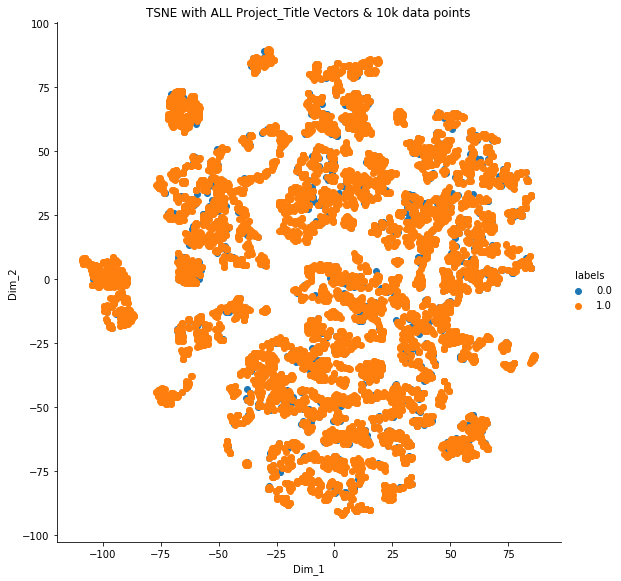

In [116]:

X_ALL_TITLES = hstack((school_state_one_hot, teacher_prefix_one_hot, project_grade_category_one_hot, 
            categories_one_hot, sub_categories_one_hot, price_standardized, 
            teacher_noppp_standardized, titles_bow, titles_tfidf,avg_w2v_vectors_titles,
            tfidf_w2v_vectors_titles)).tocsr()

X_ALL_TITLES_10000 = X_ALL_TITLES[0:10000,:]


from sklearn.manifold import TSNE

x = X_TFIDF_W2V_10000
y = labels_10000

model = TSNE(n_components=2, perplexity=30, learning_rate=300, random_state=0)

X_embedding = model.fit_transform(x.toarray())

tsne_data = model.fit_transform(X_embedding)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(tsne_data, columns=("Dim_1", "Dim_2", "labels"))


# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="labels", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE with ALL Project_Title Vectors & 10k data points')
plt.show()


### Summary

* Plotted TSNE with all categorical and numerical features and all variations of Title vector for 10K data points
* Observed that the accepted projects are more than the rejected projects.
* Accepted and Rejected classes are heavily overlaping and not seperated at this point
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors, but no major difference when compared to TSNE of AVG W2V Title vector and TSNE of Title TFIDF W2V vector

# Summary

* The objective is to automate project approval task using the text and meta data of the project
* 92706 projects were approved for funding out of 109248 applications i.e. 84.85 %
* 16542 projects were not approved for funding out of 109248 applications i.e. 15.14%
* Looks like an imbalanced dataset
* Removed np.nan values from teacher_prefix column and converted to MRS
* Removed Full stops from teacher_prefix column and converted to Upper case
* Ploted all the 51 states of United States of America with rate of acceptance using plotly.graph_objs
* Delaware (DE) is the state with Most Acceptance percentage i.e. 89.79 %
* North Dakota (ND) is the state with Second most Acceptance percentage i.e. 88.81 %
* Washington (WA) is the state with Third most Acceptance percentage i.e. 87.61 %
* Vermont state has the lowest percentage of acceptance i.e. 80.00 %
* Washington, D.C. has the second lowest percentage of acceptance i.e. 80.23 %
* Texas state has the third lowest percentage of acceptance i.e. 81.31 %
* Every state has greater than 80 % acceptance rate
* California state has the most number of project submissions i.e. 15388
* Texas state has the second most number of project submissions i.e. 7396
* Wyoming state has the second least number of project submissions i.e. 98
* Vermont state has the least number of project submissions i.e. 80
* MRS teacher_prefix has the most number of project submissions i.e. 57272 with 85.55 % acceptance rate
* MS teacher_prefix has the second most number of project submissions i.e. 38955 with 84.35 % acceptance rate
* Teacher teacher_prefix has the second least number of project submissions i.e. 2360 with 79.53 % acceptance rate
* DR teacher_prefix has the least number of project submissions i.e. 13 with 69.23 % acceptance rate
* Most number of projects are for Grades pre K - 2 i.e. 44225 with 84.87 % acceptance rate
* Second Most number of projects are for Grades 3-5 i.e. 37137 with 85.43 % acceptance rate
* Third Most number of projects are for Grades 6 - 8 i.e. 16923 with 84.25 % acceptance rate
* Least number of projects are for Grades 9 - 12 i.e. 10963 with 83.76 % acceptance rate
* Most number of projects are for Category Literacy & Language i.e. 23655 with 86.74 % acceptance rate
* Second Most number of projects are for Category Math & Science i.e. 17072 with 81.95 % acceptance rate
* Third Most number of projects are for Category Literacy, Language, Math & Science i.e. 14636 with 0.86.94 % acceptance rate
* Least number of projects are for Category AppliedLearning, Math & Science i.e. 1052 with 81.27 % acceptance rate
* More than 50 % of accepted projects have less than 250 words in their essays
* More than 50 % of rejected projects have less than 250 words in their essays
* More than 75 % of accepted projects have less than 300 words in their essays
* More than 75 % of rejected projects have less than 300 words in their essays
* All the projects prices are between 0.66 to 9999.0
* 50 % of accepted project prices are under 198.99
* 50 % of rejected project prices are under 263.145
* Accepted project prices are less when compared to rejected projects prices
* 27.46 % of teachers have posted the projects for the first time
* The first timers have posted 30014 projects with 82.13 % acceptance rate
* The maximum number of projects posted by any teacher is 451
* 93492 projects were submitted without any digits in their essays with 84.0885 % acceptance ratio
* 15756 projects were submitted without any digits in their essays with 89.4263 % acceptance ratio
* Projects with digits in their essays have 5.33 % more acceptance ratio than projects without digits
* Vectorized categorical and numerical features and stacked it with title BOW vector 
* Plotted TSNE with different Perplexity and Random_State values for 1000 data points
* After experimenting with different combinations, choosed the final values of perplexity and
    random_state as 30 and 300 respectively.
* Plotted TSNE with all categorical, numerical features and Title BOW vector for 1K, 5K and 10K data points
* Plotted TSNE with all categorical, numerical features and Title TFIDF vector for 10K data points
* Didn't find any major difference when compared to TSNE of BOW title vector
* Plotted TSNE with all categorical and numerical features and Title AVG W2V vector for 10K data points
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors
* Plotted TSNE with all categorical and numerical features and Title TFIDF W2V vector for 10K data points
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors, but no major difference when compared to TSNE of AVG W2V Title vector
* Plotted TSNE with all categorical and numerical features, Title TFIDF W2V vector and Essay TFIDF W2V vector for 10K data points
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors, but no major difference when compared to TSNE of AVG W2V Title vector and TSNE of Title TFIDF W2V vector
* Plotted TSNE with all categorical and numerical features and all variations of Title vector for 10K data points
* Found that the plot has dense data points when compared to TSNE of BOW and TFIDF title vectors, but no major difference when compared to TSNE of AVG W2V Title vector and TSNE of Title TFIDF W2V vector
* The accepted and rejected points are heavily overlaping and not seperated at this point.